## Objective - Create a ML system that detects and classifies hand-written digits

#### Import modules and prepare dataset

In [1]:
# Import sklearn/tensorflow modules.
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
%matplotlib inline

# Import other modules.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pygame
from tkinter import *
from tkinter import messagebox
from time import time
from plyer import notification
from scipy.ndimage.interpolation import shift
from skimage.transform import rescale
from random import choice

# NOTE: To import 'plyer' module, you must use 'pip install plyer'

# Getting workspace/project to create a path that leads to the dataset.
print(os.getcwd())

# Import dataset.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# NOTE: You can download these files @: https://www.kaggle.com/oddrationale/mnist-in-csv?select=mnist_train.csv

# X is the hand written digits, y is the actual digits (answers).
X_train, y_train = (train.loc[:, '1x1':'28x28'].to_numpy(), train['label'].to_numpy())
X_test, y_test = (test.loc[:, '1x1':'28x28'].to_numpy(), test['label'].to_numpy())

# X represents the hand written digits which are 28 x 28 in size.
print(f'X_train.shape: {X_train.shape}')    # -> (60,000, 784)

# Y is the actual digits they represent.
print(f'y_train.shape: {y_train.shape}')    # -> (60,000,)

print(f'X_test.shape: {X_test.shape}')    # -> (10,000, 784)
print(f'y_test.shape: {y_test.shape}')    # -> (10,000,)

pygame 2.0.0 (SDL 2.0.12, python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
c:\Users\rohan\Documents\Software Development\AI\Projects\AI Predicts Hand-Written Digits
X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)


#### Visualize the data using TSNE dimensionality technique

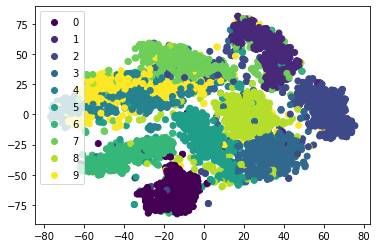

In [2]:
tsne = TSNE()

X_test_trans = tsne.fit_transform(X_test[:5000])

scatter = plt.scatter(X_test_trans[:, 0], X_test_trans[:, 1], c=y_test[:5000])
plt.legend(*scatter.legend_elements())
plt.show()

# Data is formed in clusters and looks to be linearly seperable.


#### Data analysis

0.8085755284256559
0.19142447157434403
False
174.40802874718895


Text(0.5, 1.0, 'After reform_data()')

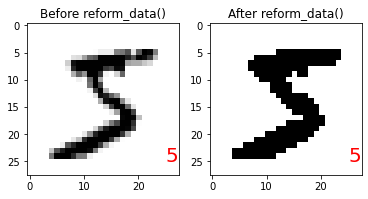

In [3]:
data = np.concatenate((X_train, X_test))
target = np.concatenate((y_train, y_test))

# Check % of data that's 0.
print(np.sum(data == 0)/data.size)    # -> 80%
print(np.sum(data != 0)/data.size)    # -> 20%

# Check for null values.
print(np.isnan(np.sum(data)))    # -> False

# Change the data so that every value is the same (0 or ___).
all_values = []

for sub_arr in data:
    for i in sub_arr:
        if i != 0:
            all_values.append(i)

print(average_val := sum(all_values)/len(all_values))    # -> 174.4

# Create scaler.
scaler = MinMaxScaler()

# Reform the data according to value.
def reform_data(arr, scale=None):
    new_arr = []
    for sub_arr in arr:
        new_arr.append([])
        index = new_arr.index([])    # Finds index of new row/sample.
        for i in sub_arr:
            if i != 0:
                new_arr[index].append(average_val)
            else:
                new_arr[index].append(0)

    return np.array(new_arr) if scale is None else scale(np.array(new_arr))

# Keep one sample to compare.
sample = X_train[0]

# Reform the data.
X_train = reform_data(X_train, scaler.fit_transform)
X_test = reform_data(X_test, scaler.transform)

# Change data to image data.
X_train = X_train.reshape((60000, 28, 28, 1)).astype('float32')
X_test = X_test.reshape((10000, 28, 28, 1)).astype('float32')

# Change to categorical data.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Check how X_train sample is now different.
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(sample.reshape(28, 28), cmap='binary')
ax1.text(25, 25, np.where(y_train[0] == 1)[0][0], fontsize=20, color='red')
ax1.set_title('Before reform_data()')

ax2.imshow(X_train[0], cmap='binary')
ax2.text(25, 25, np.where(y_train[0] == 1)[0][0], fontsize=20, color='red')
ax2.set_title('After reform_data()')


#### Apply linear model to the data

In [4]:
lin_clf = Perceptron()    # Perceptron only works when data is linear.

# NOTE: Perceptron is a neural network with only one hidden-layer.

# Reform the data for Perceptron().
reform_sklearn = lambda target : np.array([np.argmax(sample) for sample in target])

sklearn_X_trian, sklearn_X_test = (X_train.reshape(60000, 784), X_test.reshape(10000, 784))
sklearn_y_train, sklearn_y_test = (reform_sklearn(y_train), reform_sklearn(y_test))

lin_clf.fit(sklearn_X_trian, sklearn_y_train)

print(f'Perceptron train score: {lin_clf.score(sklearn_X_trian, sklearn_y_train)}')
print(f'Perceptron test score: {lin_clf.score(sklearn_X_test, sklearn_y_test)}')

Perceptron train score: 0.8878833333333334
Perceptron test score: 0.8789


#### Apply model to the data

In [4]:
def model():
    
    # Create model.
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
	
    # Compile model.
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create timer.
start_time = time()

CNN = model()
CNN.fit(X_train, y_train, epochs=10, batch_size=32)

end_time = (time() - start_time)/60

# NOTE: batch_size param means that the model will be tested on 64 samples at a time.
#       This save a ton of RAM.

print(train_score := 'CNN Train Score: {:.2f}'.format(CNN.evaluate(X_train, y_train, verbose=False)[1]*100))
print(test_score := 'CNN Test Score: {:.2f}'.format(CNN.evaluate(X_test, y_test, verbose=False)[1]*100))
print(elapsed := f'Elapsed: {end_time:.2f} min.')

# Notify when done.
notification.notify(
    title='Neural Network Training Results',
    message=f'{train_score}\n{test_score}\n{elapsed}',
    app_icon='python_icon.ico'
)

Epoch 1/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1954 - accuracy: 0.9406
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0693 - accuracy: 0.9788
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0438 - accuracy: 0.9863
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0291 - accuracy: 0.9912
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0190 - accuracy: 0.9947
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0128 - accuracy: 0.9966
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0083 - accuracy: 0.9982
Epoch 8/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0053 - accuracy: 0.9989
Epoch 9/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0031 - accuracy: 0.9996
Epoch 10/10
1875/1875 [==============================] - 25s 13m

#### Test the model through visualizations

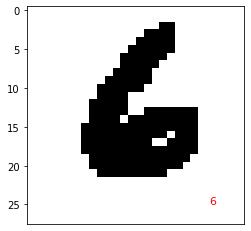

In [11]:
# Create a list of predictions.
sample = np.array(choice(X_test).reshape(1, 28, 28, 1))
prediction = np.argmax(CNN.predict(sample))

sample_img = sample.reshape(28, 28)

plt.imshow(sample_img, cmap='binary')
plt.text(23, 25, prediction, fontsize=11, color='red')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)